Loading libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from bokeh.io import output_notebook, push_notebook, show, curdoc
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider, CustomJS
from bokeh.layouts import widgetbox, row, column
import numpy as np
from sklearn.metrics import mean_squared_error
output_notebook()

Loading BokehJS ...

# loading data

## Description
In the 1880's, Francis Galton was developing ways to quantify the heritability of traits. As part of this work, he collected data on the heights of adult children and their parents.

## Format
A data frame with 898 observations on the following variables.
family a factor with levels for each family
father the father's height (in inches)
mother the mother's height (in inches)
sex the child's sex: F or M
height the child's height as an adult (in inches)
nkids the number of adult children in the family, or, at least, the number whose heights Galton recorded.

## Details
Entries were deleted for those children whose heights were not recorded numerically by Galton, who sometimes used entries such as “tall”, “short”, “idiotic”, “deformed” and so on.

In [2]:
df_galton = pd.read_csv('Galton.txt', sep='\t')
source = ColumnDataSource(df_galton)

In [3]:
df_galton.head(10)

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4
5,2,75.5,66.5,M,72.5,4
6,2,75.5,66.5,F,65.5,4
7,2,75.5,66.5,F,65.5,4
8,3,75.0,64.0,M,71.0,2
9,3,75.0,64.0,F,68.0,2


# Exploratory data analysis

Father's mean: 69.2328507795 Child's mean: 66.7606904232


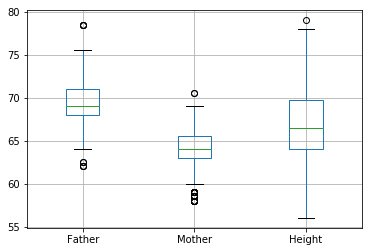

In [4]:
df_galton[['Father','Mother', 'Height']].boxplot()
print("Father's mean:", df_galton['Father'].mean(), "Child's mean:", df_galton['Height'].mean())

In [5]:
slope, intercept = np.polyfit(df_galton['Father'], df_galton['Height'], deg=1)

# Trying to find out the best model that fits data

In [6]:
hover = HoverTool(tooltips=[("(x,y)", "($x, $y)")])
mapper = CategoricalColorMapper(factors=['M', 'F'], palette=['green', 'blue'])
plot1 = figure(x_axis_label='Father', y_axis_label='Child', plot_width=400, plot_height=400, tools=[hover, 'crosshair', 'box_select, lasso_select', 'pan,box_zoom'])
c = plot1.circle('Father', 'Height', source=source, hover_color='red', color={'field': 'Gender', 'transform': mapper})

In [7]:
X = [df_galton['Father'].min(), df_galton['Father'].max()]
y = [x * slope + intercept for x in X]
line_source = ColumnDataSource({'x':X, 'y':y, 'i': np.repeat(intercept, len(X)), 's':np.repeat(slope, len(X))})
l = plot1.line('x', 'y', source=line_source, line_color='orange')

In [8]:
weights, step = np.linspace(-1,1.8,100, retstep=True)
loss = [mean_squared_error(df_galton['Height'], df_galton['Father'] * slope + intercept) for slope in weights]
loss_source = ColumnDataSource({'x':weights, 'y':loss})
point_source = ColumnDataSource({'x':[weights[0]], 'y':[loss[0]]})
plot2 = figure(x_axis_label='Weights (slopes)', y_axis_label='Loss (Cost/Error)', plot_width=400, plot_height=400, tools=[hover, 'crosshair', 'box_select, lasso_select', 'pan,box_zoom'])
l2 = plot2.line('x', 'y', source=loss_source)
c2 = plot2.circle('x', 'y', source=point_source, color='red', size=5)

In [9]:
callback_slope = CustomJS(args=dict(line=line_source, source=source, point=point_source), code="""
    var line_data = line.data;
    var source_data = source.data;
    var point_data = point.data;
    var new_s = cb_obj.value
    
    var x = line_data['x']
    var y = line_data['y']
    var i = line_data['i']
    var s = line_data['s']
    var p1 = point_data['x']
    var p2 = point_data['y']
    
    for (var j = 0; j < x.length; j++) {
        s[j] = new_s
        y[j] = x[j] * new_s + i[j]
    }
    
    father = source_data['Father'];    
    y_pred = [];
    for (var j = 0; j < father.length; j++) {
        y_pred[j] = father[j] * new_s + i[0]
    }
    
    var sum = 0;
    child = source_data['Height'];
    for (var j = 0; j < child.length; j++) {
        sum = sum + Math.pow((child[j] - y_pred[j]), 2);
    }
    
    for (var j = 0; j < p1.length; j++) {
        p1[j] = s[0]
        p2[j] = (sum / child.length)
    }
    
    line.change.emit();
    point.change.emit();
""")

slider_slope = Slider(start=-1, end=1.8, value=1.6, step=step, title="slope")
slider_slope.js_on_change('value', callback_slope)

In [10]:
callback_intercept = CustomJS(args=dict(line=line_source, source=source, point=point_source), code="""
    var line_data = line.data;
    var source_data = source.data;
    var point_data = point.data;
    var new_i = cb_obj.value
    
    var x = line_data['x']
    var y = line_data['y']
    var i = line_data['i']
    var s = line_data['s']
    var p1 = point_data['x']
    var p2 = point_data['y']
    
    for (var j = 0; j < x.length; j++) {
        i[j] = new_i
        y[j] = x[j] * s[j] + new_i
    }
    
    father = source_data['Father'];    
    y_pred = [];
    for (var j = 0; j < father.length; j++) {
        y_pred[j] = father[j] * s[0] + new_i
    }
    
    var sum = 0;
    child = source_data['Height'];
    for (var j = 0; j < child.length; j++) {
        sum = sum + Math.pow((child[j] - y_pred[j]), 2);
    }
    
    for (var j = 0; j < p1.length; j++) {
        p1[j] = s[0]
        p2[j] = (sum / child.length)
    }
    
    line.change.emit();
    point.change.emit();
""")

slider_intercept = Slider(start=0, end=100, value=66, step=1, title="intercept")
slider_intercept.js_on_change('value', callback_intercept)

In [11]:
layout = column(row(slider_intercept, slider_slope),row(plot1, plot2))
show(layout, notebook_handle=True)